#### Imports

In [1]:
# Basic imports & versions
import sys, os, json, time, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from utils.env_utils import keep_only_electrical_storage, keep_only_core_observations, PPOTrainLogger, DiscretizeActionWrapper, PowerScaledDiscreteActions
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-09-16 10:11:36.464610: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-16 10:11:36.478372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758010296.493615 4028323 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758010296.497848 4028323 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758010296.509402 4028323 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


#### Variables

In [ ]:
# Configuration
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/ppo'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv' 
ACTION_LABELS = ['discharge_max', 'discharge_half', 'hold', 'charge_half', 'charge_max']
ONLY_ELECTRICAL_STORAGE = True
EVAL_EPISODES = 10
INT_TO_FRAC = np.array([-1.0, -0.5, 0.0, 0.5, 1.0], dtype=np.float32)

In [3]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN 

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema)
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


In [5]:
# Keep only one building: 1-D action
one_building = "Building_1"
schema_1b = dict(schema)  # shallow copy
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}
if not schema_1b['buildings']:
    raise RuntimeError(f"{one_building} not found in schema['buildings']")

env = CityLearnEnv(schema_1b, central_agent=True) # create env
# check initialization
print('Initial time step:', env.time_step)
print('Number of time steps:', env.time_steps)
print('Central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Action_space [Box(low_limit, high_limit), shape, datatype]:', env.action_space)
print('Number of Observations:', len(env.observations[0]))

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-16_10-11-43'
Initial time step: 0
Number of time steps: 2208
Central agent: True
Number of buildings: 1
Electrical storage capacity: {'Building_1': 4.0}
Action_space [Box(low_limit, high_limit), shape, datatype]: [Box(-1.0, 1.0, (1,), float32)]
Number of Observations: 6


In [ ]:
class RewardScalar(gym.Wrapper):
    """Macht aus CityLearn-Reward (Liste oder Array) einen Float für SB3/Monitor."""
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        # reward kann Liste / np.array / Skalar sein -> robust zu Float machen
        reward = float(np.asarray(reward).sum())
        return obs, reward, terminated, truncated, info

def compute_action_scales(cl_env, alpha=0.8):
    """scale = alpha * (P_nom * dt / capacity). alpha<1 gibt Headroom -> weniger Clipping."""
    dt_h = cl_env.schema['seconds_per_time_step'] / 3600.0
    scales = []
    for b in cl_env.buildings:
        cap  = max(b.electrical_storage.capacity, 1e-9)   # kWh
        pnom = b.electrical_storage.nominal_power         # kW
        scales.append(alpha * (pnom * dt_h) / cap)
    return np.array(scales, dtype=np.float32)

os.makedirs(LOG_DIR, exist_ok=True)
scales = compute_action_scales(env) 
print("Action scales (pro Building):", scales)

train_env = NormalizedObservationWrapper(env)
train_env = StableBaselines3Wrapper(train_env)
train_env = PowerScaledDiscreteActions(train_env, scales=scales)
print('Train action_space:', train_env.action_space)

train_env = Monitor(train_env, filename=os.path.join(LOG_DIR, "monitor.csv"))
train_callback = PPOTrainLogger()
TOTAL_TIMESTEPS = 2208 * 50

model = PPO(
    policy='MlpPolicy',
    env=train_env,
    seed=1, # seed for pseudo random generators
    device='cpu', # ppo is intended to run on cpu
    learning_rate=0.00284168226539535,
    gamma=0.971587814014358,
    ent_coef=0.05885182459088836,
    vf_coef=0.9901724232320459,
    gae_lambda=0.884166238447603,
    n_steps=64,
    batch_size=128,
    n_epochs=8,
    clip_range=0.21369082195658376,
    verbose=1, # logging: info
    policy_kwargs=dict(net_arch=[256,256], activation_fn=th.nn.ReLU)
)
TRAINING_FILE = "ppo_03" # num

Action scales (pro Building): [0.664]
Train action_space: Discrete(5)
Using cpu device
Wrapping the env in a DummyVecEnv.


In [ ]:
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=train_callback)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save(TRAINING_FILE)  
print(f"PPO model saved to {os.path.abspath(TRAINING_FILE)}")

print("---------------Train callback: \n", train_callback.df)
print("---------------Episode rewards: \n", train_callback.ep_df)
# Save training logs
TRAIN_STEPS_FILE = os.path.join(LOG_DIR, "ppo_train_steps_03.csv") # num
TRAIN_EPISODES_FILE = os.path.join(LOG_DIR, "ppo_train_episodes_03.csv") # num
train_callback.df.to_csv(TRAIN_STEPS_FILE, index=False)
train_callback.ep_df.to_csv(TRAIN_EPISODES_FILE, index=False)

Total time elapsed for 88320 steps: 0.02 seconds
PPO model saved to /hkfs/home/haicore/iai/cj9272/ppo_03


In [ ]:
# Quick learning check on training episodes
if hasattr(train_callback, 'ep_df') and len(train_callback.ep_df):
    ep_df = train_callback.ep_df
    first_n, last_n = 10, 10
    first_mean = ep_df['return'].head(first_n).mean()
    last_mean  = ep_df['return'].tail(last_n).mean()
    print(f'First {first_n} ep mean return: {first_mean:.3f}')
    print(f'Last  {last_n} ep mean return: {last_mean:.3f}')
    print('Learning indicator (last - first):', f'{(last_mean-first_mean):.3f}')
else:
    print('No episode returns in train_callback.ep_df')

No episode returns in logger.ep_df


#### Evaluation

In [ ]:
schema_eval = copy.deepcopy(schema_1b)
eval_env = CityLearnEnv(schema_eval, central_agent=True)
eval_scales = compute_action_scales(eval_env) 

eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
eval_env = PowerScaledDiscreteActions(eval_env, scales=eval_scales)

print('Eval action_space:', eval_env.action_space)

model = PPO.load(TRAINING_FILE) 
print(f"PPO model loaded from {os.path.abspath(TRAINING_FILE)}")      
EVAL_FILE = os.path.join(LOG_DIR, "ppo_eval_01.pkl")

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-16_10-11-50'
Eval action_space: Discrete(5)
PPO model loaded from /hkfs/home/haicore/iai/cj9272/ppo_03


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
# Enhanced eval: timings, episode length, per-step stats, deterministic toggle.
def evaluate_with_metrics(model, env, episodes=5, deterministic=True, render=False, save_path=None):
    import pickle
    from citylearn.citylearn import CityLearnEnv

    def action_to_frac(env, action):
        if isinstance(env.action_space, gym.spaces.Discrete):
            return np.array([INT_TO_FRAC[int(action)]], dtype=np.float32)
        elif isinstance(env.action_space, gym.spaces.MultiDiscrete):
            a = np.asarray(action, dtype=int)
            return INT_TO_FRAC[a]
        else:
            return np.asarray(action, dtype=np.float32)

    def _get_base_env(e):
        cur, seen = e, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        raise RuntimeError("CityLearnEnv not found inside wrappers.")

    base = _get_base_env(env)
    bld_names = [b.name for b in base.buildings]
    building_name = "Building_1" if "Building_1" in bld_names else bld_names[0]
    b_idx = bld_names.index(building_name)

    obs_names = getattr(base, "observation_names", None)
    if obs_names is None:
        raise AttributeError("CityLearnEnv has no 'observation_names'.")
    obs_b = obs_names[b_idx]
    name_to_idx = {n: i for i, n in enumerate(obs_b)}
    i_net = name_to_idx.get("net_electricity_consumption")
    if i_net is None:
        i_net = name_to_idx.get("net_electricity_consumption_without_storage")
    i_nsl   = name_to_idx.get("non_shiftable_load")
    i_price = name_to_idx.get("electricity_pricing")
    i_solar = name_to_idx.get("solar_generation")

    ep_metrics, all_step_rewards, all_kpis, all_actions = [], [], [], []
    ep_lengths = []
    actions_disc_list, ep_action_fracs = [], []
    ep_rewards_list = []
    ep_net_load, ep_non_shiftable_load, ep_price, ep_solar_generation = [], [], [], []

    t_global_start = time.time()

    for ep in range(1, episodes + 1):
        obs, _ = env.reset()
        done = False
        ep_ret, ep_len = 0.0, 0
        step_rewards = []
        action_list = []
        last_info = None


        ep_actions_disc = []
        ep_fracs = []
        ep_net, ep_nsl, ep_prc, ep_sol = [], [], [], []

        t_ep_start = time.time()
        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            frac = action_to_frac(env, action)
            action_list.append(frac)

            obs, r, terminated, truncated, info = env.step(action)
            last_info = info
            done = bool(terminated or truncated)
            # central Agent -> r is list of length 1
            if isinstance(r, (list, tuple, np.ndarray)):
                r = float(r[0])

            # Optionaler Sanity-Check mit Monitor:
            if isinstance(last_info, dict) and 'episode' in last_info:
                assert abs(ep_ret - float(last_info['episode']['r'])) < 1e-5

            if isinstance(env.action_space, gym.spaces.Discrete):
                a_id = int(action)
            else:
                a_id = int(np.argmin(np.abs(INT_TO_FRAC - float(frac[0]))))

            ep_actions_disc.append(a_id)
            ep_fracs.append(float(INT_TO_FRAC[a_id]))
            step_rewards.append(float(r))
            ep_ret += float(r)
            ep_len += 1

            raw = base.observations[b_idx]
            ep_net.append(float(raw[i_net]) if i_net is not None else np.nan)
            ep_nsl.append(float(raw[i_nsl]) if i_nsl is not None else np.nan)
            ep_prc.append(float(raw[i_price]) if i_price is not None else np.nan)
            ep_sol.append(float(raw[i_solar]) if i_solar is not None else np.nan)

            if render:
                env.render()

        kpis = env.unwrapped.evaluate()
        all_kpis.append(kpis)
        all_actions.append(np.vstack(action_list))

        t_ep = time.time() - t_ep_start
        steps_per_sec = ep_len / max(t_ep, 1e-9)
        ep_metrics.append({
            'episode': ep, 'cumulative reward': ep_ret, 'length': ep_len,
            'mean_reward': ep_ret/ep_len if ep_len else np.nan,
            'min_step_reward': float(np.min(step_rewards)),
            'max_step_reward': float(np.max(step_rewards)),
            'std_step_reward': float(np.std(step_rewards)),
            'steps_per_sec': steps_per_sec, 'wall_time_s': t_ep
        })
        all_step_rewards.extend(step_rewards)

        ep_lengths.append(ep_len)
        actions_disc_list.append(np.asarray(ep_actions_disc, dtype=int))
        ep_action_fracs.append(np.asarray(ep_fracs, dtype=float))
        ep_rewards_list.append(np.asarray(step_rewards, dtype=float))
        ep_net_load.append(np.asarray(ep_net, dtype=float))
        ep_non_shiftable_load.append(np.asarray(ep_nsl, dtype=float))
        ep_price.append(np.asarray(ep_prc, dtype=float))
        ep_solar_generation.append(np.asarray(ep_sol, dtype=float))

        print(f"[Eval] Ep {ep}/{episodes} return={ep_ret:.3f} len={ep_len} "
              f"mean={ep_ret/ep_len:.3f} time={t_ep:.2f}s speed={steps_per_sec:.1f} steps/s")

    print(f"Total eval time: {time.time()-t_global_start:.2f}s  | Avg/ep: {(time.time()-t_global_start)/episodes:.2f}s")
    metrics_df = pd.DataFrame(ep_metrics)
    display(metrics_df)

    price_file = schema['buildings'][building_name]['pricing']
    price_path = os.path.join(ROOT_DIR, price_file)
    prc_df = pd.read_csv(price_path)
    T = len(prc_df)

    results = {
        'ep_lengths': np.asarray(ep_lengths, dtype=int),
        'actions_disc_list': actions_disc_list,
        'step_rewards': np.asarray(all_step_rewards, dtype=float),

        'ep_action_fracs': ep_action_fracs,
        'ep_rewards_list': ep_rewards_list,
        'ep_net_load': ep_net_load,
        'ep_non_shiftable_load': ep_non_shiftable_load,
        'ep_price': ep_price,
        'ep_solar_generation': ep_solar_generation,

        'price_df': prc_df,
        'episode_len': T,
        'building_name': building_name,

        'metrics_df': metrics_df,
        'episode_kpis': all_kpis,
    }

    if save_path is not None:
        with open(save_path, "wb") as f:
            pickle.dump(results, f)
        print(f"PPO eval results saved to {os.path.abspath(save_path)}")

    return metrics_df, np.array(all_step_rewards), all_kpis, all_actions

# Deterministic
metrics_det, step_rewards_det, kpis_det, actions_det = evaluate_with_metrics(
    model, eval_env, episodes=EVAL_EPISODES, deterministic=True, save_path=EVAL_FILE
)

[Eval] Ep 1/10 return=-272.638 len=2207 mean=-0.124 time=114.69s speed=19.2 steps/s
[Eval] Ep 2/10 return=-272.638 len=2207 mean=-0.124 time=114.84s speed=19.2 steps/s
[Eval] Ep 3/10 return=-272.638 len=2207 mean=-0.124 time=114.73s speed=19.2 steps/s
[Eval] Ep 4/10 return=-272.638 len=2207 mean=-0.124 time=114.68s speed=19.2 steps/s
[Eval] Ep 5/10 return=-272.638 len=2207 mean=-0.124 time=114.73s speed=19.2 steps/s
[Eval] Ep 6/10 return=-272.638 len=2207 mean=-0.124 time=114.95s speed=19.2 steps/s
[Eval] Ep 7/10 return=-272.638 len=2207 mean=-0.124 time=114.74s speed=19.2 steps/s
[Eval] Ep 8/10 return=-272.638 len=2207 mean=-0.124 time=114.89s speed=19.2 steps/s
[Eval] Ep 9/10 return=-272.638 len=2207 mean=-0.124 time=114.91s speed=19.2 steps/s
[Eval] Ep 10/10 return=-272.638 len=2207 mean=-0.124 time=115.38s speed=19.1 steps/s
Total eval time: 1148.61s  | Avg/ep: 114.86s


,episode,cumulative reward,length,mean_reward,min_step_reward,max_step_reward,std_step_reward,steps_per_sec,wall_time_s
0,1,-272.638349,2207,-0.123533,-1.757477,0.157346,0.158075,19.242730,114.692665
1,2,-272.638349,2207,-0.123533,-1.757477,0.157346,0.158075,19.218092,114.839703
2,3,-272.638349,2207,-0.123533,-1.757477,0.157346,0.158075,19.236847,114.727742
3,4,-272.638349,2207,-0.123533,-1.757477,0.157346,0.158075,19.245109,114.678487
4,5,-272.638349,2207,-0.123533,-1.757477,0.157346,0.158075,19.235637,114.734960
5,6,-272.638349,2207,-0.123533,-1.757477,0.157346,0.158075,19.199743,114.949455
6,7,-272.638349,2207,-0.123533,-1.757477,0.157346,0.158075,19.234382,114.742444
7,8,-272.638349,2207,-0.123533,-1.757477,0.157346,0.158075,19.210443,114.885430
8,9,-272.638349,2207,-0.123533,-1.757477,0.157346,0.158075,19.206626,114.908261
9,10,-272.638349,2207,-0.123533,-1.757477,0.157346,0.158075,19.127737,115.382182


PPO eval results saved to /hkfs/home/haicore/iai/cj9272/ppo_eval_results.pkl


In [10]:
def preview_rewards(model, env, steps=48, deterministic=True):
    obs, _ = env.reset()
    cum = 0.0
    for t in range(steps):
        action, _ = model.predict(obs, deterministic=deterministic)
        obs, r, done, trunc, info = env.step(action)
        # CityLearn gibt bei central_agent i.d.R. eine Liste zurück
        r = float(r[0]) if isinstance(r, (list, tuple, np.ndarray)) else float(r)
        cum += r
        print(f"[eval] t={t:04d} r={r:.4f}  cum={cum:.4f}")
        if done or trunc:
            print(f"[eval] episode end at t={t}, return={cum:.4f}")
            break

# Aufrufen, sobald model & eval_env bereit sind:
preview_rewards(model, eval_env, steps=96, deterministic=True)

[eval] t=0000 r=-0.0926  cum=-0.0926
[eval] t=0001 r=-0.0390  cum=-0.1317
[eval] t=0002 r=-0.0282  cum=-0.1599
[eval] t=0003 r=-0.0245  cum=-0.1844
[eval] t=0004 r=-0.0297  cum=-0.2141
[eval] t=0005 r=-0.0728  cum=-0.2870
[eval] t=0006 r=-0.1487  cum=-0.4357
[eval] t=0007 r=-0.0160  cum=-0.4516
[eval] t=0008 r=-0.3530  cum=-0.8046
[eval] t=0009 r=-0.1443  cum=-0.9489
[eval] t=0010 r=0.1045  cum=-0.8445
[eval] t=0011 r=-0.0090  cum=-0.8534
[eval] t=0012 r=0.0046  cum=-0.8489
[eval] t=0013 r=0.0023  cum=-0.8466
[eval] t=0014 r=0.0057  cum=-0.8408
[eval] t=0015 r=-0.0591  cum=-0.8999
[eval] t=0016 r=-0.2139  cum=-1.1139
[eval] t=0017 r=-0.0448  cum=-1.1586
[eval] t=0018 r=-0.0519  cum=-1.2105
[eval] t=0019 r=-0.1467  cum=-1.3572
[eval] t=0020 r=-0.1280  cum=-1.4851
[eval] t=0021 r=-0.0908  cum=-1.5759
[eval] t=0022 r=-0.0546  cum=-1.6306
[eval] t=0023 r=-0.0793  cum=-1.7099
[eval] t=0024 r=-0.0706  cum=-1.7804
[eval] t=0025 r=-0.0417  cum=-1.8221
[eval] t=0026 r=-0.0293  cum=-1.8514
[eval

#### Optuna

In [ ]:
# Optuna objective + study creation for PPO (add as a new cell)
import os, copy, json
import numpy as np
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

WORKER_ID = int(os.getenv("OPTUNA_WORKER_ID", "0"))
ART_DIR = os.path.join(os.getcwd(), "artifacts")
os.makedirs(ART_DIR, exist_ok=True)
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_ppo.db')}?timeout=120"
STUDY_NAME = "ppo_citylearn"

def make_env_one_building(schema_src, building_name="Building_1", n_bins=5, monitor=False):
    schema_1b = copy.deepcopy(schema_src)
    schema_1b['buildings'] = {k: v for k, v in schema_src['buildings'].items() if k == building_name}
    if not schema_1b['buildings']:
        raise RuntimeError(f"{building_name} not found in schema['buildings']")
    env = CityLearnEnv(schema_1b, central_agent=True)
    env_scales = compute_action_scales(env) 
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)
    env = PowerScaledDiscreteActions(env, scales=env_scales)
    #env = DiscretizeActionWrapper(env, n_bins=n_bins)
    if monitor:
        env = Monitor(env)
    return env

def evaluate_mean_reward(model, env, episodes=2, deterministic=True):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_ret = 0.0
        while not done:
            act, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, _ = env.step(act)
            ep_ret += float(r)
            done = bool(terminated or truncated)
        rewards.append(ep_ret)
    return float(np.mean(rewards))

class OptunaEvalPruningCallback:
    def __init__(self, trial, model, eval_env, eval_every_steps, eval_episodes=2):
        self.trial = trial
        self.model = model
        self.eval_env = eval_env
        self.eval_every_steps = int(eval_every_steps)
        self.eval_episodes = int(eval_episodes)
        self._last_step = 0
        self.is_pruned = False

    def __call__(self, locals_, globals_):
        # Called by SB3 when using callback= in learn (old-style callable)
        step = int(locals_.get("self").num_timesteps)
        if step - self._last_step >= self.eval_every_steps:
            self._last_step = step
            mean_r = evaluate_mean_reward(self.model, self.eval_env, episodes=self.eval_episodes, deterministic=True)
            self.trial.report(mean_r, step=step)
            if self.trial.should_prune():
                self.is_pruned = True
                return False  # stop training
        return True

def objective(trial: optuna.Trial) -> float:
    # Search space (PPO-relevant)
    lr         = trial.suggest_float("learning_rate", 1e-5, 3e-3, log=True)
    gamma      = trial.suggest_float("gamma", 0.90, 0.9999)
    ent_coef   = trial.suggest_float("ent_coef", 0.0, 0.1)
    vf_coef    = trial.suggest_float("vf_coef", 0.0, 1.0)
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 1.0)
    n_steps    = trial.suggest_categorical("n_steps", [8, 16, 32, 64])
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    n_epochs   = trial.suggest_int("n_epochs", 3, 10)
    clip_range = trial.suggest_float("clip_range", 0.1, 0.3)
    net_key    = trial.suggest_categorical("net_arch", ["128x128", "256x256", "256x256x256"])
    net_arch   = [int(x) for x in net_key.split("x")]

    # Build envs
    train_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=True)
    eval_env  = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    T = train_env.unwrapped.time_steps

    # keep trials short
    episodes_per_trial = 3
    total_steps = episodes_per_trial * T

    model = PPO(
        policy="MlpPolicy",
        env=train_env,
        seed=0,
        learning_rate=lr,
        gamma=gamma,
        n_steps=n_steps,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        gae_lambda=gae_lambda,
        batch_size=batch_size,
        n_epochs=n_epochs,
        clip_range=clip_range,
        verbose=0,
        policy_kwargs=dict(net_arch=net_arch, activation_fn=th.nn.ReLU),
        device="auto",
    )

    cb = OptunaEvalPruningCallback(trial, model, eval_env, eval_every_steps=max(1, T//2), eval_episodes=2)
    try:
        model.learn(total_timesteps=total_steps, callback=cb)
        if cb.is_pruned:
            raise optuna.TrialPruned()
    finally:
        try: train_env.close()
        except: pass
        try: eval_env.close()
        except: pass

    # final evaluation
    eval_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    score = evaluate_mean_reward(model, eval_env, episodes=3, deterministic=True)
    eval_env.close()

    trial.set_user_attr("final_mean_reward", score)
    return score

print(f"PID: {os.getpid()}")

study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    storage=STORAGE_URL,
    load_if_exists=True,
    sampler=TPESampler(seed=None, multivariate=False),
    pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=3, min_early_stopping_rate=0),
)
print("Study ready:", STUDY_NAME, STORAGE_URL, "worker:", WORKER_ID)

[I 2025-09-16 11:16:14,827] Using an existing study with name 'ppo_citylearn' instead of creating a new one.


PID: 4028323
Study ready: ppo_citylearn sqlite:////hkfs/home/haicore/iai/cj9272/artifacts/optuna_ppo.db?timeout=120 worker: 0


In [ ]:
# Optuna hyperparameter optimization (run)
#N_TRIALS = 30  # increase as needed
N_TRIALS = None  # let timeout drive the run
TIMEOUT_SECONDS = int((3*3600 + 40*60) / 2)  # 6600 seconds per worker
study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT_SECONDS, gc_after_trial=True, catch=(Exception,))
print("Done. Trials now:", len(study.trials))

In [11]:
# Print best Trial + Top 10 Trials and store best trial params in artifacts/best_params_*.json
import os, json
import optuna
from collections import defaultdict

ART_DIR = os.path.join(os.getcwd(), "artifacts")
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_ppo.db')}?timeout=120"
STUDY_NAME = "ppo_citylearn"

try:
    study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)
except Exception as e:
    print("Study konnte nicht geladen werden:", e)
    raise

best = study.best_trial
print("Best trial number:", best.number)
print("Best value (objective):", best.value)
print("Best params:")
for k, v in best.params.items():
    print(f"  {k}: {v}")

# Top-K completed trials (by objective value)
top_k = 10
completed = [t for t in study.trials if t.value is not None]
completed_sorted = sorted(completed, key=lambda t: t.value, reverse=True)[:top_k]
print(f"\nTop {min(top_k, len(completed_sorted))} trials (number, value):")
for t in completed_sorted:
    print(f"  #{t.number}\t{t.value}\t{t.params}")

# Per-parameter summary (unique values seen)
param_vals = defaultdict(set)
for t in study.trials:
    for k, v in t.params.items():
        param_vals[k].add(v)

print("\nParameter summary (unique values seen):")
for k in sorted(param_vals.keys()):
    vals = list(param_vals[k])
    print(f"  {k}: {len(vals)} unique (examples: {vals[:6]})")

# Save best params to artifacts
os.makedirs(ART_DIR, exist_ok=True)
out_path = os.path.join(ART_DIR, f"best_params_{STUDY_NAME}.json")
with open(out_path, "w") as f:
    json.dump({"trial": int(best.number), "value": float(best.value), "params": best.params}, f, indent=2)
print("\nSaved best params to:", out_path)

Best trial number: 15
Best value (objective): -262.39356545284363
Best params:
  learning_rate: 0.00284168226539535
  gamma: 0.971587814014358
  ent_coef: 0.05885182459088836
  vf_coef: 0.9901724232320459
  gae_lambda: 0.884166238447603
  n_steps: 64
  batch_size: 128
  n_epochs: 8
  clip_range: 0.21369082195658376
  net_arch: 256x256

Top 10 trials (number, value):
  #15	-262.39356545284363	{'learning_rate': 0.00284168226539535, 'gamma': 0.971587814014358, 'ent_coef': 0.05885182459088836, 'vf_coef': 0.9901724232320459, 'gae_lambda': 0.884166238447603, 'n_steps': 64, 'batch_size': 128, 'n_epochs': 8, 'clip_range': 0.21369082195658376, 'net_arch': '256x256'}
  #0	-265.46900342672353	{'learning_rate': 0.0002288113668475521, 'gamma': 0.9714474177006047, 'ent_coef': 0.06027633760716439, 'vf_coef': 0.5448831829968969, 'gae_lambda': 0.8847309598677809, 'n_steps': 64, 'batch_size': 128, 'n_epochs': 7, 'clip_range': 0.2851193276585322, 'net_arch': '256x256'}
  #1	-265.46900342672353	{'learning

#### Plots

Plotting actions for building: Building_1 (index 0)


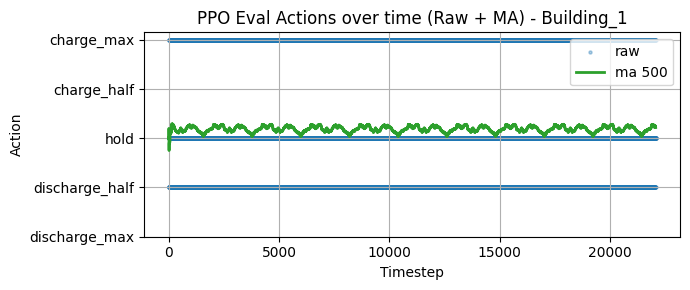

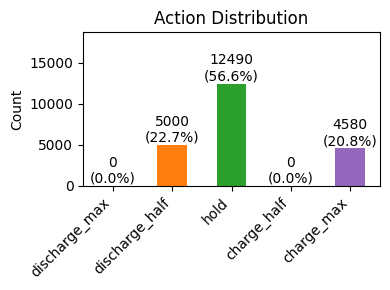

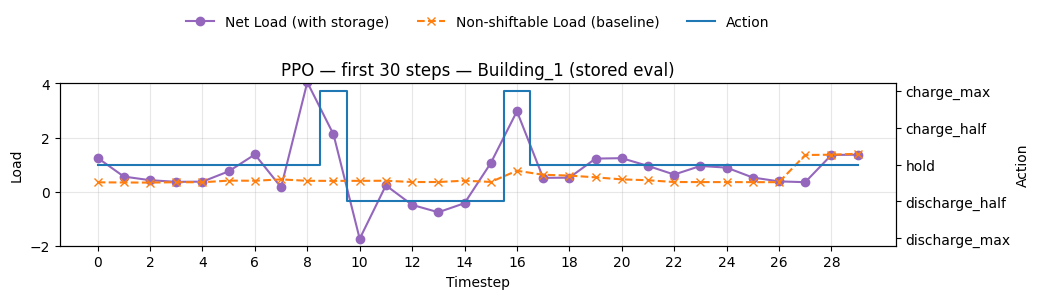

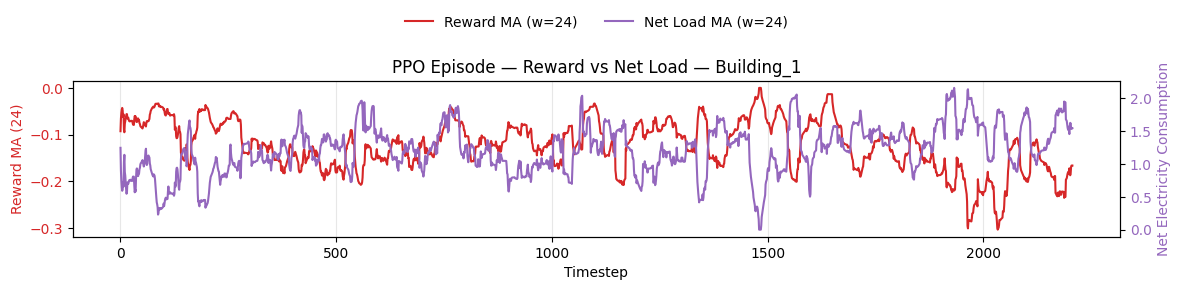

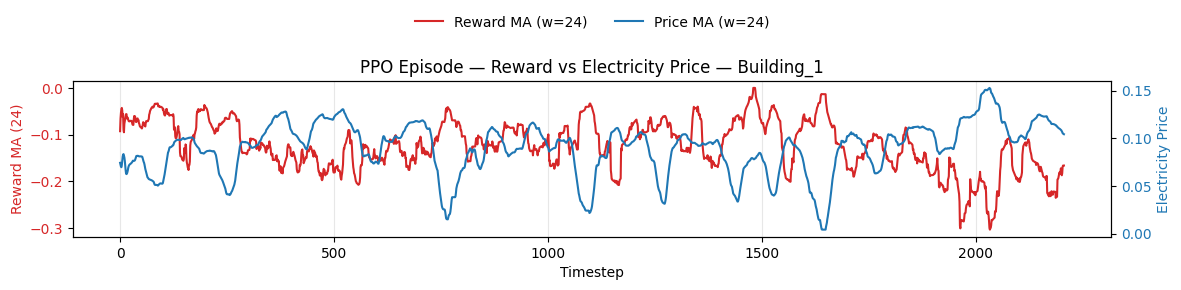

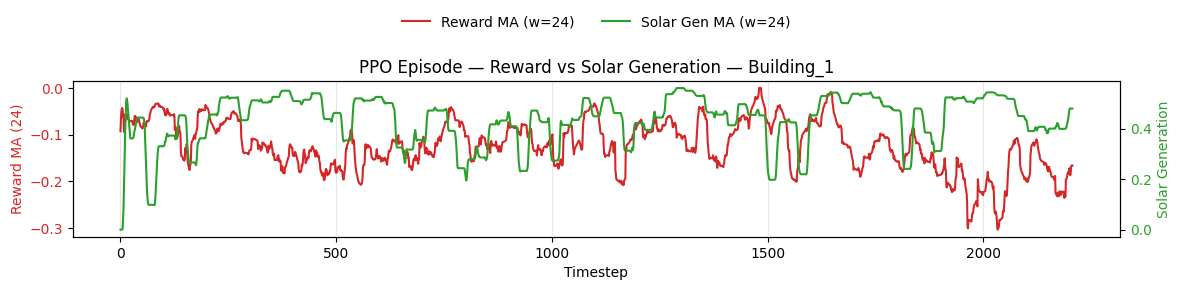

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from citylearn.citylearn import CityLearnEnv
from matplotlib.ticker import MultipleLocator
import pickle

def _ensure_ppo_eval_results(path=EVAL_FILE):
    """Return cached PPO eval results if present; else load from file."""
    global er_ppo
    if 'er_ppo' in globals() and isinstance(er_ppo, dict):
        return er_ppo
    if os.path.exists(path):
        with open(path, "rb") as f:
            er_ppo = pickle.load(f)
        print(f"PPO eval results loaded from {os.path.abspath(path)}.")
        return er_ppo
    raise FileNotFoundError(f"{path} not found. Run evaluate_with_metrics(..., save_path=EVAL_FILE) first.")

# Load saved PPO eval
er = _ensure_ppo_eval_results()

# Rebuild actions_det and metrics_det from file (like A2C)
if 'ep_action_fracs' in er:
    actions_det = [np.asarray(ep, dtype=float)[:, None] for ep in er['ep_action_fracs']]
elif 'actions_disc_list' in er:
    actions_det = [INT_TO_FRAC[np.asarray(ep, dtype=int)][:, None] for ep in er['actions_disc_list']]
else:
    raise KeyError("No action sequences found in PPO eval results.")

metrics_det = er.get('metrics_df', None)
if metrics_det is None or not isinstance(metrics_det, pd.DataFrame):
    ep_lengths = np.asarray(er.get('ep_lengths', [len(x) for x in actions_det]), dtype=int)
    metrics_det = pd.DataFrame({'episode': np.arange(1, len(ep_lengths)+1), 'length': ep_lengths})

# Prefer building name from file if present
building_name = er.get('building_name', 'Building_1')

# Choose a building to visualize
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if building_name not in bld_names:
    building_name = bld_names[0]
b_idx = bld_names.index(building_name)
print(f'Plotting actions for building: {building_name} (index {b_idx})')

# Flatten evaluated actions across episodes -> shape (total_steps, n_actions)
actions_arr = np.concatenate(actions_det, axis=0)  # each item shape (ep_len, n_actions)
n_actions = actions_arr.shape[1]
total_steps = actions_arr.shape[0]

# Build episode boundaries from metrics
ep_lengths = metrics_det['length'].to_numpy()
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(total_steps)

# Load pricing for the chosen building
price_file = schema['buildings'][building_name]['pricing']
price_path = os.path.join(ROOT_DIR, price_file)
prc = pd.read_csv(price_path)
T = len(prc)  # usually 2208

# Helper: map continuous action to 5 RBC-like labels by nearest of [-1,-0.5,0,0.5,1]
bin_centers = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
def cont_to_label(vals):
    idx = np.argmin(np.abs(vals[..., None] - bin_centers[None, ...]), axis=-1)
    return idx  # 0..4

# ----- Plot 1: Actions over Time (for selected building) -----
window = 500
act_series = actions_arr[:, b_idx]
act_ma = pd.Series(act_series).rolling(window, min_periods=1).mean().to_numpy()

plt.figure(figsize=(7,3))
plt.scatter(hour_index, act_series, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'ma {window}')
plt.title(f'PPO Eval Actions over time (Raw + MA) - {building_name}')
plt.xlabel('Timestep'); plt.ylabel('Action'); plt.grid(True); plt.legend(loc='upper right')
plt.yticks(ticks=INT_TO_FRAC.tolist(), labels=ACTION_LABELS)
plt.tight_layout(); plt.show()

# ----- Plot 2: Action Distribution (quantized to 5 bins like RBC) -----
plt.figure(figsize=(4,3))
labels_idx = cont_to_label(act_series)
counts = pd.Series(labels_idx).value_counts().reindex(range(5)).fillna(0).astype(int)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()


def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

def add_top_legend(ax_left, ax_right=None, ncol=3, y=1.50, top=0.84, loc='upper center', frameon=False):
    """Place a combined legend above the plot using lines from one or two axes."""
    handles = []
    for ax in (ax_left, ax_right):
        if ax is None:
            continue
        handles.extend(ax.get_lines())
    labels = [h.get_label() for h in handles]
    legend = ax_left.legend(handles, labels, loc=loc, bbox_to_anchor=(0.5, y), ncol=ncol, frameon=frameon)
    if top is not None:
        plt.subplots_adjust(top=top)
    return legend

def capture_ep_series_ppo(building_name="Building_1", episode_idx=0, max_steps=None):
    """Build per-step DataFrame from saved PPO eval_results; no env stepping."""
    er = _ensure_ppo_eval_results()
    needed = ['ep_action_fracs','ep_rewards_list','ep_net_load','ep_non_shiftable_load','ep_price','ep_solar_generation']
    missing = [k for k in needed if k not in er]
    if missing:
        raise ValueError(f"ppo eval_results missing keys: {missing}. Re-run evaluate_with_metrics to regenerate.")
    n_eps = len(er['ep_rewards_list'])
    if not (0 <= episode_idx < n_eps):
        raise IndexError(f"episode_idx {episode_idx} out of range 0..{n_eps-1}")

    if 'actions_disc_list' in er and er['actions_disc_list'] and len(er['actions_disc_list']) > episode_idx:
        a_id = np.asarray(er['actions_disc_list'][episode_idx], dtype=int)
    else:
        frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
        a_id = np.argmin(np.abs(frac[:, None] - INT_TO_FRAC[None, :]), axis=1)

    a_frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
    rew    = np.asarray(er['ep_rewards_list'][episode_idx], dtype=float)
    net    = np.asarray(er['ep_net_load'][episode_idx], dtype=float)
    nsl    = np.asarray(er['ep_non_shiftable_load'][episode_idx], dtype=float)
    price  = np.asarray(er['ep_price'][episode_idx], dtype=float)
    solar  = np.asarray(er['ep_solar_generation'][episode_idx], dtype=float)
    L = len(rew)
    if max_steps is not None:
        L = min(L, int(max_steps))
        a_id, a_frac, rew, net, nsl, price, solar = (
            a_id[:L], a_frac[:L], rew[:L], net[:L], nsl[:L], price[:L], solar[:L]
        )
    df = pd.DataFrame({
        't': np.arange(L, dtype=int),
        'action_id': a_id,
        'action_frac': a_frac,
        'reward': rew,
        'net_load': net,
        'non_shiftable_load': nsl,
        'price': price,
        'solar_generation': solar,
    })
    return df, er.get('building_name', building_name)

def plot_first_30_steps_actions_vs_loads_ppo(building_name="Building_1", episode_idx=0):
    """Plot first 30 steps using stored eval."""
    df30, bname = capture_ep_series_ppo(building_name, episode_idx=episode_idx, max_steps=30)
    t = df30['t'].to_numpy()
    net = df30['net_load'].to_numpy()
    nsl = df30['non_shiftable_load'].to_numpy()
    act = df30['action_frac'].to_numpy()

    fig, ax1 = plt.subplots(figsize=(10.5, 3.6))
    ax1.plot(t, net, color='C4', marker='o', label='Net Load (with storage)')
    ax1.plot(t, nsl, color='C1', ls='--', marker='x', label='Non-shiftable Load (baseline)')
    ax1.set_xlabel('Timestep')
    ax1.set_xticks(t[::2])
    ax1.set_ylabel('Load')
    ax1.set_ylim(-2, 4)
    ax1.yaxis.set_major_locator(MultipleLocator(2))
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', label='Action')
    ax2.set_ylabel('Action')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks(INT_TO_FRAC.tolist())
    try:
        ax2.set_yticklabels(ACTION_LABELS)
    except Exception:
        ax2.set_yticklabels(['discharge_max', 'discharge_half', 'hold', 'charge_half', 'charge_max'])
    add_top_legend(ax1, ax2)
    plt.title(f'PPO — first 30 steps — {bname} (stored eval)')
    plt.tight_layout()
    plt.show()

def plot_ep1_reward_vs_obs_ppo(building_name="Building_1", episode_idx=0):
    """Three plots using stored eval for selected episode."""
    df, bname = capture_ep_series_ppo(building_name, episode_idx=episode_idx, max_steps=None)
    window_reward = 24
    window_x = 24
    t = df['t'].to_numpy()
    reward_ma = pd.Series(df['reward']).rolling(window_reward, min_periods=1).mean().to_numpy()
    price_ma  = pd.Series(df['price']).rolling(window_x, min_periods=1).mean().to_numpy()
    solar_ma  = pd.Series(df['solar_generation']).rolling(window_x, min_periods=1).mean().to_numpy()
    net_ma    = pd.Series(df['net_load']).rolling(window_x, min_periods=1).mean().to_numpy()

    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')
    ax2.set_ylabel('Net Electricity Consumption', color='C4'); ax2.tick_params(axis='y', labelcolor='C4')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'PPO Episode — Reward vs Net Load — {bname}')
    plt.tight_layout(); plt.show()

    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, price_ma, color='C0', label=f'Price MA (w={window_x})')
    ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'PPO Episode — Reward vs Electricity Price — {bname}')
    plt.tight_layout(); plt.show()

    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w={window_x})')
    ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'PPO Episode — Reward vs Solar Generation — {bname}')
    plt.tight_layout(); plt.show()

# ----- Plot 3: Actions vs Loads (first 30 steps) from file -----
plot_first_30_steps_actions_vs_loads_ppo(building_name=building_name, episode_idx=0)

# ----- Plot 4,5,6: Reward vs Observations (stored eval) -----
plot_ep1_reward_vs_obs_ppo(building_name=building_name, episode_idx=0)

In [15]:
# Quick action-distribution sanity check (quantize to 5 bins)
import pickle, pandas as pd, numpy as np
er = _ensure_ppo_eval_results(path=EVAL_FILE)
if 'ep_action_fracs' in er:
    a = np.concatenate([np.asarray(ep) for ep in er['ep_action_fracs']])
    bins = np.array([-1.0, -0.5, 0.0, 0.5, 1.0], dtype=float)
    idx = np.argmin(np.abs(a[:, None] - bins[None, :]), axis=1)
    dist = pd.Series(idx).value_counts().reindex(range(5)).fillna(0).astype(int)
    total = dist.sum()
    print('PPO action distribution (bin 0..4):', dist.to_dict())
    print('PPO action distribution pct:', {i: f'{int(v)} ({v/total:.1%})' for i,v in dist.items()})
else:
    print("No 'ep_action_fracs' in eval results; check evaluate_with_metrics output.")

PPO action distribution (bin 0..4): {0: 0, 1: 5000, 2: 12490, 3: 0, 4: 4580}
PPO action distribution pct: {0: '0 (0.0%)', 1: '5000 (22.7%)', 2: '12490 (56.6%)', 3: '0 (0.0%)', 4: '4580 (20.8%)'}


#### Heatmap

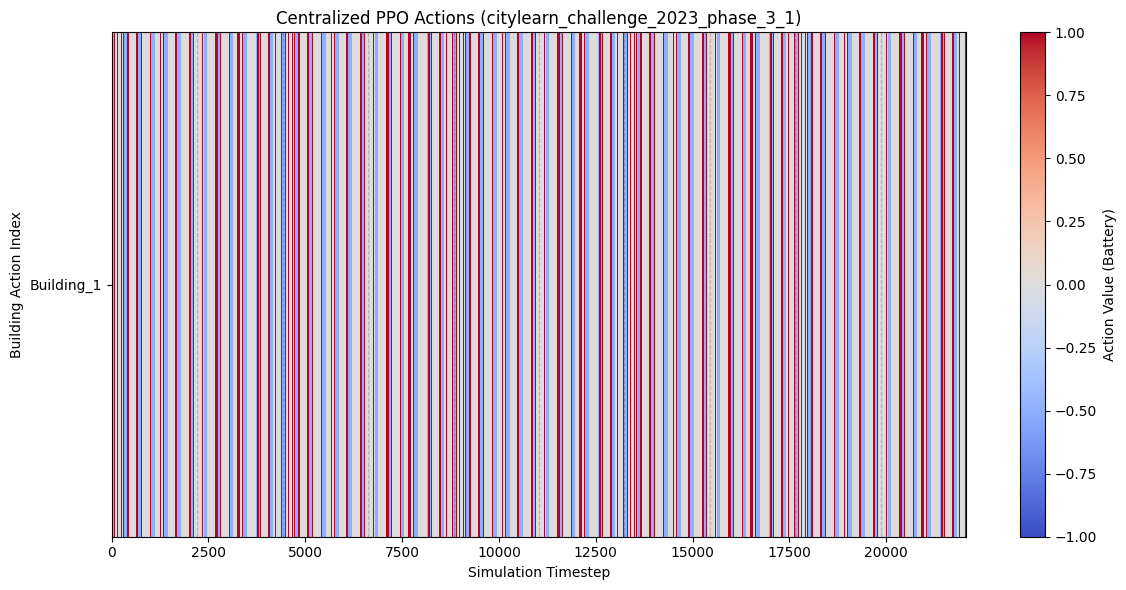

In [16]:
# Heatmap of centralized PPO actions across buildings and timesteps (eval episodes concatenated)
import os
import numpy as np
import matplotlib.pyplot as plt

# Require evaluated actions
assert 'actions_det' in globals() and len(actions_det) > 0, "Run evaluate_with_metrics first."

# Flatten list[(ep_len, n_actions)] -> (total_steps, n_actions)
actions_arr = np.concatenate(actions_det, axis=0)
n_steps, n_actions = actions_arr.shape

# Episode boundaries for vertical lines
ep_lengths = metrics_det['length'].to_numpy() if 'metrics_det' in globals() else np.array([n_steps])
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))

# Building labels
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if len(bld_names) != n_actions:
    bld_names = [f'Act {i}' for i in range(n_actions)]

# Output dir
results_dir = os.path.join(os.getcwd(), 'results')
os.makedirs(results_dir, exist_ok=True)

plt.figure(figsize=(12, 6))
plt.imshow(actions_arr.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Action Value (Battery)')
plt.xlabel('Simulation Timestep')
plt.ylabel('Building Action Index')
plt.yticks(np.arange(n_actions), bld_names)

# Mark episode boundaries
for off in ep_offsets[1:]:
    plt.axvline(off, color='k', ls='--', lw=0.8, alpha=0.2)

plt.title(f'Centralized PPO Actions ({DATASET_NAME})')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'ppo_actions_heatmap.png'), dpi=150)
plt.show()